In [1]:
import torch
import gpytorch
import numpy as np
from src.plotting import plot_train_test_split, plot_grid
from src.metric_report import IndepSVIGPReport, MultitaskGPReport
from src import data_loader as dl
from src.data_loader import PVDataLoader, PVDataGenerator
from src.metric_report import IndepSVIGPReport, MultitaskGPReport
from src.kernel import generate_quasi_periodic
from src.beta_likelihood import BetaLikelihood_MeanParametrization


In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 100
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 55
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [3]:
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 0 sec



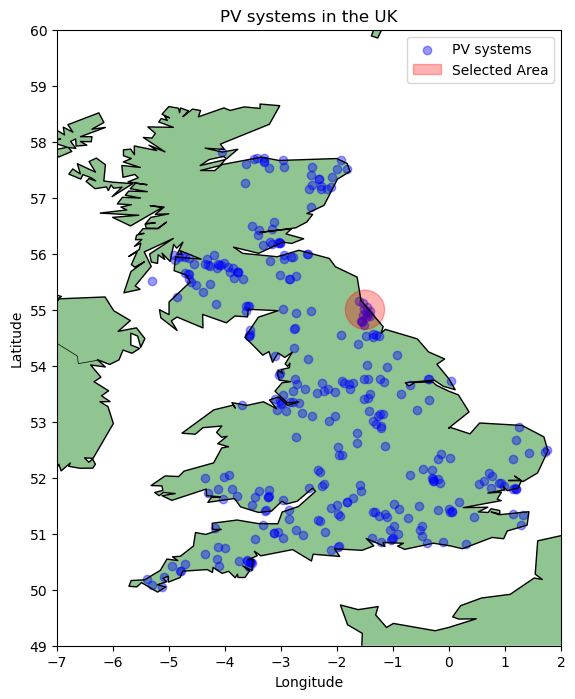

In [4]:
plot_grid(df_location, CIRCLE_COORDS, distance_method='circle', radius=RADIUS)

In [5]:
loader = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    drop_nan=False)

X, y = loader.get_time_series()

N_TASKS = y.size(-1)
NUM_LATENT = 5

==> Loading data
==> Loaded data in: 0 m : 15 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [6]:
x_list, y_list = dl.cross_val_fold(X, y, N_DAYS_TRAIN, DAILY_DATA_POINTS)

In [7]:
x_train, y_train, x_test, y_test =  dl.train_test_split_fold(x_list, y_list, N_HOURS_PRED, DAILY_DATA_POINTS, DAY_MIN, DAY_MAX)

In [8]:
train_loader = PVDataLoader(x_train, y_train)
test_loader = PVDataLoader(x_test, y_test)

In [13]:
x_sample, y_sample = next(iter(train_loader))


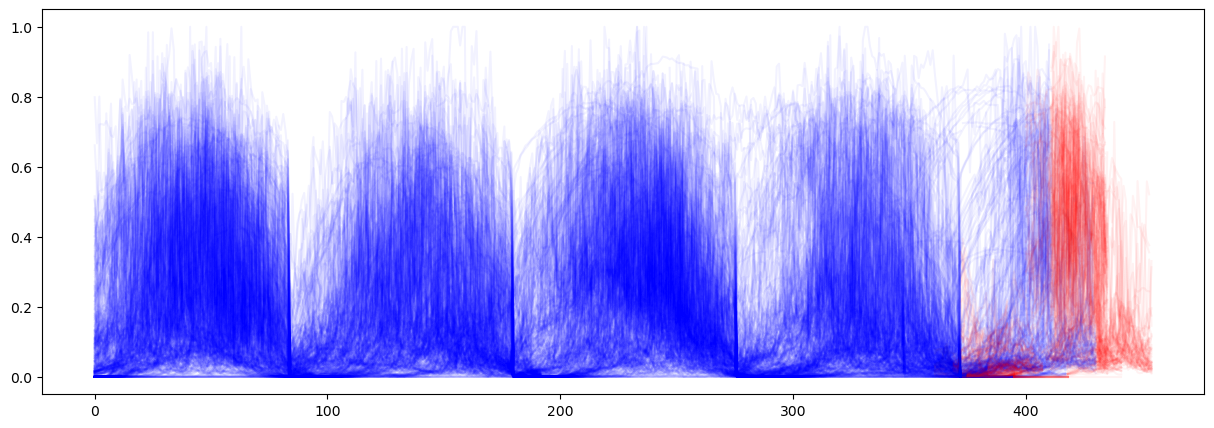

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 5))

for (x_tr, y_tr), (x_te, y_te) in zip(train_loader, test_loader):
    plt.plot(x_tr[:,0].numpy(), y_tr.numpy(), color='b', alpha=0.05)
    plt.plot(x_te[:,0].numpy(), y_te.numpy(), color='r', alpha=0.05)

EVALUATION ROUTINE BASED ON THIS CV FOLDS
- all models should run across the lists generated from the data loader, then give a final metric report as .txt files

In [12]:
covar_module = generate_quasi_periodic(1)
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([1]))
likelihood = BetaLikelihood_MeanParametrization(scale=15, batch_shape=torch.Size([1]))

In [39]:
svi_beta = IndepSVIGPReport(train_loader=train_loader,
                    test_loader=test_loader,
                    mean_module=mean_module,
                    covar_module=covar_module,
                    likelihood=likelihood)
svi_beta.generate_metrics()
svi_beta.write_report('svi_beta')

Iter 30/300 - Loss: -2.197
Iter 60/300 - Loss: -2.743
Iter 90/300 - Loss: -2.893
Iter 120/300 - Loss: -2.926
Iter 150/300 - Loss: -2.936
Iter 180/300 - Loss: -2.942
Iter 210/300 - Loss: -2.947
Iter 240/300 - Loss: -2.950
Iter 270/300 - Loss: -2.954
Iter 300/300 - Loss: -2.957
Iter 30/300 - Loss: -3.737
Iter 60/300 - Loss: -3.831
Iter 90/300 - Loss: -3.846
Iter 120/300 - Loss: -3.857
Iter 150/300 - Loss: -3.865
Iter 180/300 - Loss: -3.871
Iter 210/300 - Loss: -3.876
Iter 240/300 - Loss: -3.880
Iter 270/300 - Loss: -3.883
Iter 300/300 - Loss: -3.886
Iter 30/300 - Loss: -2.911
Iter 60/300 - Loss: -3.033
Iter 90/300 - Loss: -3.041
Not PSD error, adding jitter
Iter 30/300 - Loss: -2.850
Iter 60/300 - Loss: -3.017


In [10]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=N_TASKS)
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([NUM_LATENT]))
covar_module = generate_quasi_periodic(num_latents=NUM_LATENT)

In [11]:
multitask_gp = MultitaskGPReport(train_loader=train_loader,
                    test_loader=test_loader,
                    mean_module=mean_module,
                    covar_module=covar_module,
                    num_latents=NUM_LATENT)

In [18]:
# read csv seperated by ',' into a pandas dataframe
import pandas as pd

df_15 = pd.read_csv('svi_beta_const_scale15.csv', sep=',')
df_30 = pd.read_csv('svi_beta_zero_scale30.csv', sep=',')

In [19]:
df_15.describe()

,Unnamed: 0,nlpd,mae_mean,mae_median,mae_mode
count,385.000000,385.000000,385.000000,385.000000,385.000000
mean,192.000000,0.008183,0.118103,0.117403,0.117780
std,111.284171,0.161616,0.094497,0.097233,0.101606
min,0.000000,-0.427975,0.010615,0.007329,0.002396
25%,96.000000,-0.082640,0.039884,0.038175,0.038439
50%,192.000000,-0.016971,0.093071,0.090250,0.088177
75%,288.000000,0.071693,0.172695,0.171625,0.170304
max,384.000000,1.083827,0.484041,0.492567,0.506850


In [20]:
df_30.describe()

,Unnamed: 0,nlpd,mae_mean,mae_median,mae_mode
count,385.000000,385.000000,385.000000,385.000000,385.000000
mean,192.000000,0.124707,0.280933,0.273381,0.266017
std,111.284171,0.205839,0.075639,0.071201,0.066413
min,0.000000,-0.168136,0.107734,0.111895,0.121898
25%,96.000000,-0.007568,0.237236,0.230051,0.224062
50%,192.000000,0.046238,0.297118,0.286755,0.273692
75%,288.000000,0.193899,0.338915,0.325935,0.312927
max,384.000000,1.743966,0.430627,0.429025,0.443194
